> ***PACKAGES***

In [1]:
import numpy as np 
import pandas as pd
import os, cv2, random, time, shutil, csv
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
np.random.seed(42)
%matplotlib inline 
import json
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, Lambda, Dropout, InputLayer, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from keras import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.preprocessing.image import load_img

# ***IMPORT DOG BREED DATASET***

In [2]:
train_dir = '/kaggle/input/dog-breed-identification/train/'
test_dir = '/kaggle/input/dog-breed-identification/test/'

# ***PROCESSING LABELS***

In [3]:
labels_dataframe = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
labels_dataframe.head()
dog_breeds = sorted(list(set(labels_dataframe['breed'])))
dog_breeds[:10]

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle']

In [4]:
##NUMBER OF DOG BREEDS
n_classes = len(dog_breeds)
print(n_classes)

120


In [5]:
labels_dataframe.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


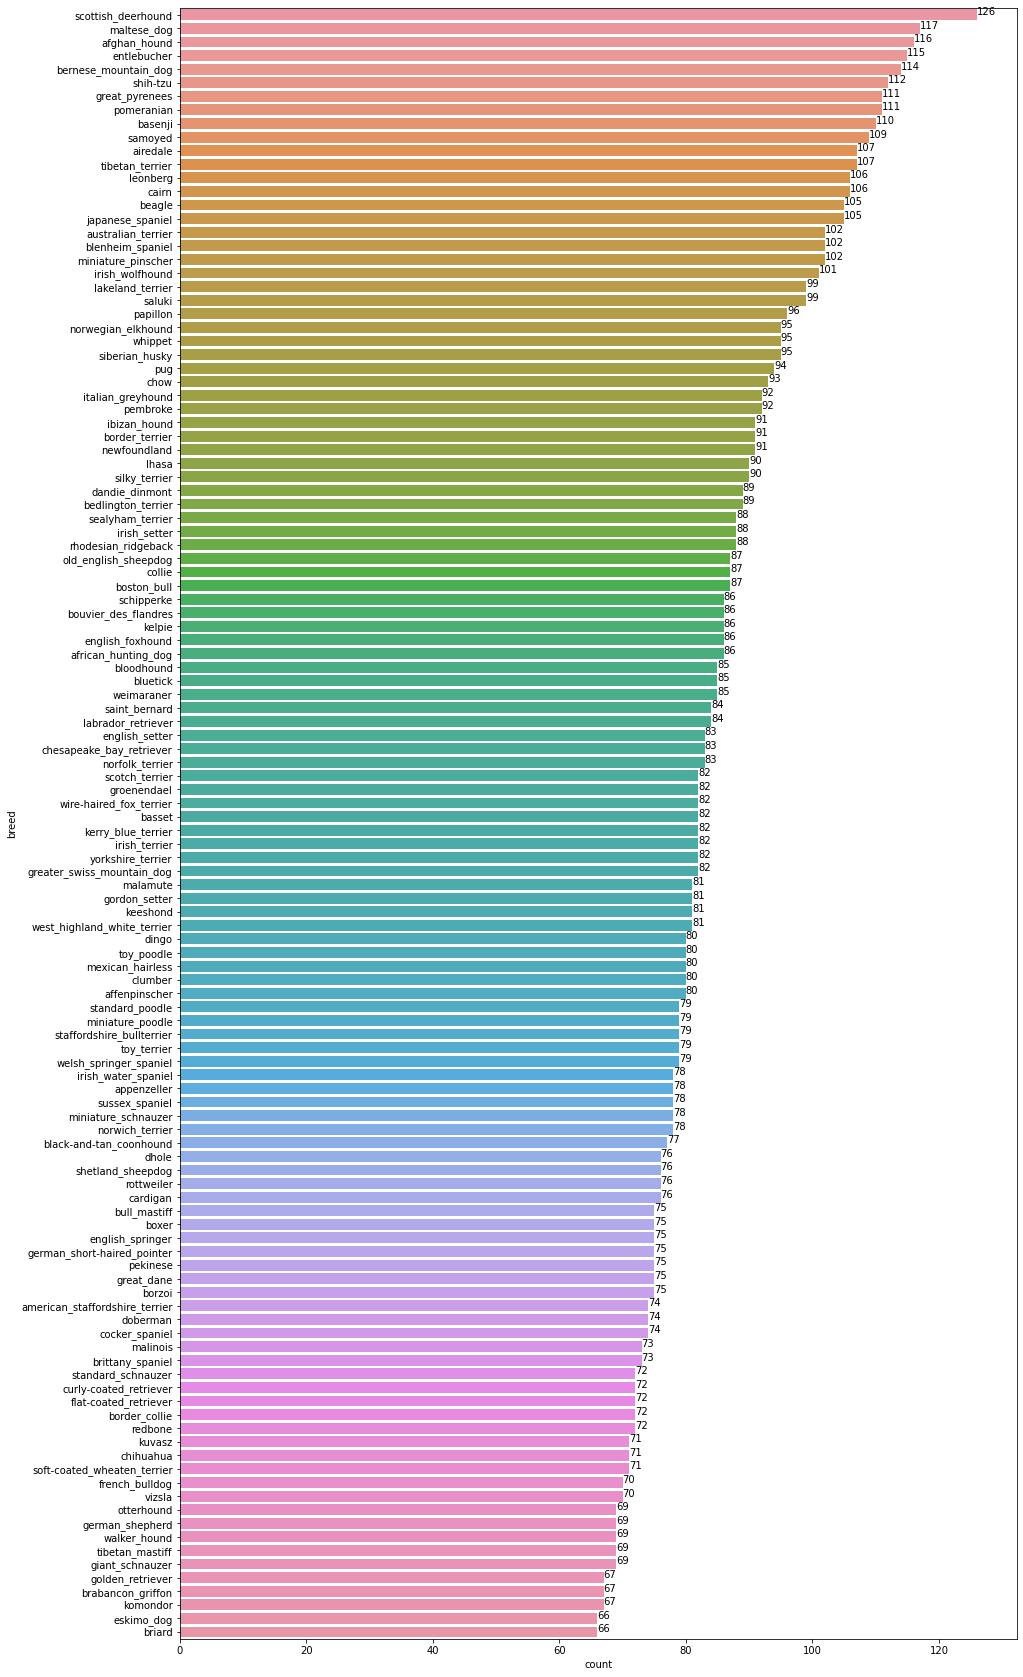

In [6]:
def barw(ax): 
    
    for p in ax.patches:
        val = p.get_width() 
        x = p.get_x()+ p.get_width()  
        y = p.get_y() + p.get_height()/2 
        ax.annotate(round(val,2),(x,y))
        
plt.figure(figsize = (15,30))
ax0 =sns.countplot(y=labels_dataframe['breed'],order=labels_dataframe['breed'].value_counts().index)
barw(ax0)
plt.show()

In [7]:
labels_dataframe['file_name'] = labels_dataframe['id'].apply(lambda x:train_dir+f"{x}.jpg")
labels_dataframe.head()

,id,breed,file_name
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,/kaggle/input/dog-breed-identification/train/0...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,/kaggle/input/dog-breed-identification/train/0...
2,001cdf01b096e06d78e9e5112d419397,pekinese,/kaggle/input/dog-breed-identification/train/0...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,/kaggle/input/dog-breed-identification/train/0...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,/kaggle/input/dog-breed-identification/train/0...


In [8]:
labels_dataframe.head(5)['file_name'][0]

'/kaggle/input/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg'

In [9]:
class_to_num = dict(zip(dog_breeds, range(n_classes)))
class_to_num

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [10]:
codes = []
for index, data in labels_dataframe.iterrows():
    breed = data['breed']
    codes.append(class_to_num[breed])
y = to_categorical(codes)

# ***MODEL BUILDING***

**IMAGE SIZE**

In [11]:
input_shape = (331,331,3)
input_layer = Input(shape=input_shape)

**IMPORTING PRE-TRAINED MODELS**

In [12]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as resnet_preprocess
preprocessor_resnet = Lambda(resnet_preprocess)(input_layer)
inception_resnet = InceptionResNetV2(weights = 'imagenet',include_top = False,input_shape = input_shape,pooling ='avg')(preprocessor_resnet)

2022-11-15 11:42:37.436004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 11:42:37.588271: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 11:42:37.589133: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 11:42:37.590748: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

219070464/219055592 [==============================] - 10s 0us/step


In [13]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess
preprocessor_inception = Lambda(inception_preprocess)(input_layer)
inception_v3 = InceptionV3(weights = 'imagenet',include_top = False,input_shape = input_shape,pooling ='avg')(preprocessor_inception)

87924736/87910968 [==============================] - 3s 0us/step


In [14]:
from keras.applications.xception import Xception, preprocess_input as xception_preprocess
preprocessor_xception = Lambda(xception_preprocess)(input_layer)
xception = Xception(weights = 'imagenet',include_top = False,input_shape = input_shape,pooling ='avg')(preprocessor_xception)

83697664/83683744 [==============================] - 3s 0us/step


In [15]:
from keras.applications.nasnet import NASNetLarge, preprocess_input as nasnet_preprocess
preprocessor_nasnet = Lambda(nasnet_preprocess)(input_layer)
nasnet = NASNetLarge(weights = 'imagenet',include_top = False,input_shape = input_shape,pooling ='avg')(preprocessor_nasnet)

343621632/343610240 [==============================] - 12s 0us/step


In [16]:
from keras.applications.resnet_v2 import ResNet50V2, preprocess_input as resnet_v2_preprocess
preprocessor_resnet = Lambda(resnet_v2_preprocess)(input_layer)
resnet = ResNet50V2(weights = 'imagenet',include_top = False,input_shape = input_shape,pooling ='avg')(preprocessor_resnet)

94683136/94668760 [==============================] - 4s 0us/step


In [17]:
from keras.applications.densenet import DenseNet121, preprocess_input as densenet_preprocess
preprocessor_inception = Lambda(densenet_preprocess)(input_layer)
densenet = DenseNet121(weights = 'imagenet',include_top = False,input_shape = input_shape,pooling ='avg')(preprocessor_inception)

29097984/29084464 [==============================] - 1s 0us/step


**BUILDING DNN MODELS**

**MODEL 1**

In [18]:
from keras.layers.merge import concatenate
merge_1 = concatenate([inception_resnet,inception_v3,xception])
model_1 = Model(inputs = input_layer, outputs = merge_1)

In [19]:
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 331, 331, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 331, 331, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 331, 331, 3)  0           input_1[0][0]                    
______________________________________________________________________________________________

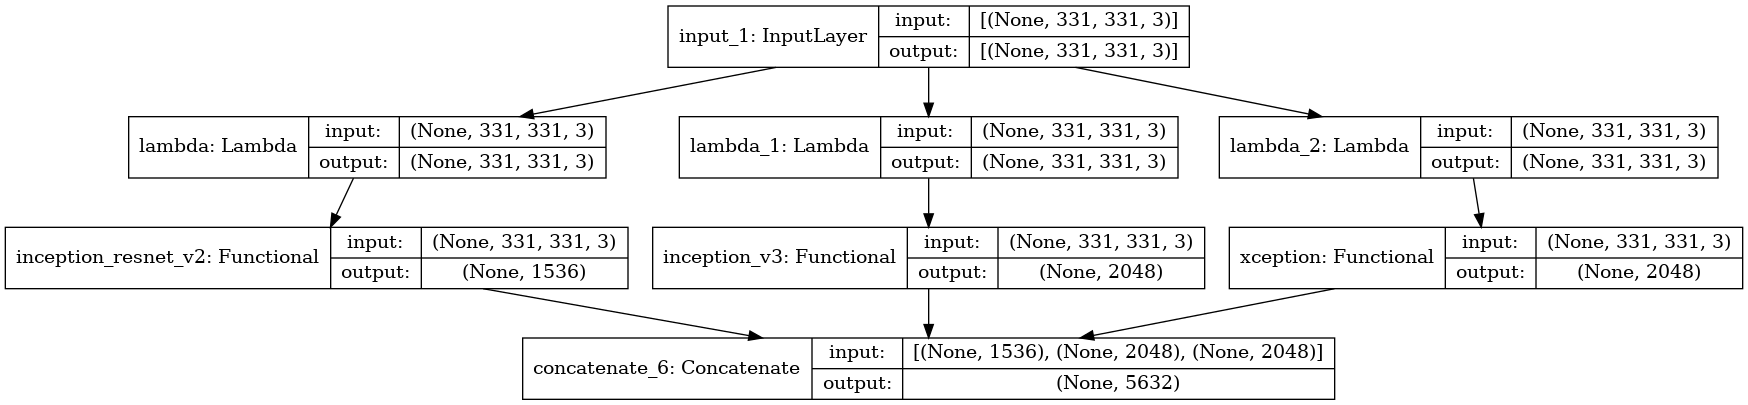

In [20]:
from keras.utils.vis_utils import plot_model
plot_model(model_1,show_shapes = True)

**MODEL 2**

In [21]:
merge_2 = concatenate([inception_resnet,inception_v3,xception,nasnet])
model_2 = Model(inputs = input_layer, outputs = merge_2)

In [22]:
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 331, 331, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 331, 331, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 331, 331, 3)  0           input_1[0][0]                    
____________________________________________________________________________________________

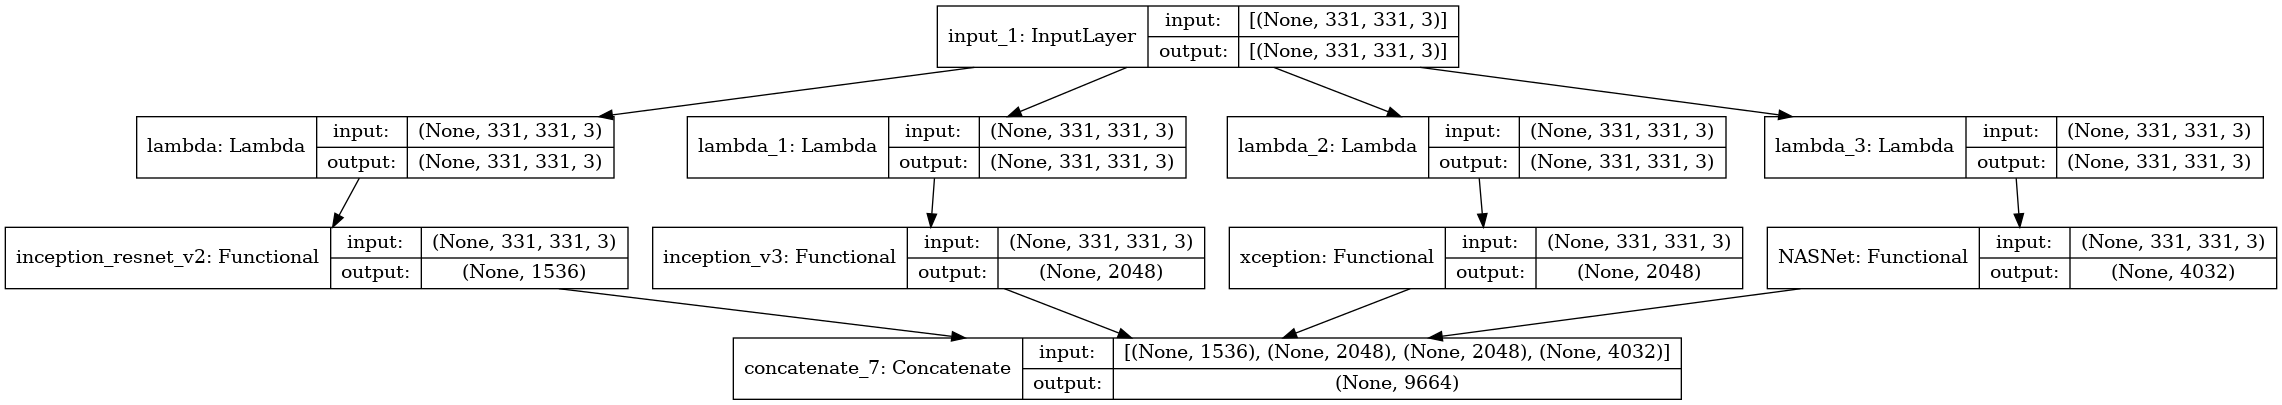

In [23]:
plot_model(model_2,show_shapes = True)

**MODEL 3**

In [24]:
merge_ix = concatenate([inception_v3, xception])
model = Model(inputs = input_layer, outputs = merge_ix)

merge_in = concatenate([nasnet,inception_resnet])
model1 = Model(inputs = input_layer, outputs = merge_in)

merge_3 = concatenate([merge_ix,merge_in])
model_3=Model(inputs = input_layer, outputs = merge_3)

In [25]:
model_3.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 331, 331, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 331, 331, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 331, 331, 3)  0           input_1[0][0]                    
____________________________________________________________________________________________

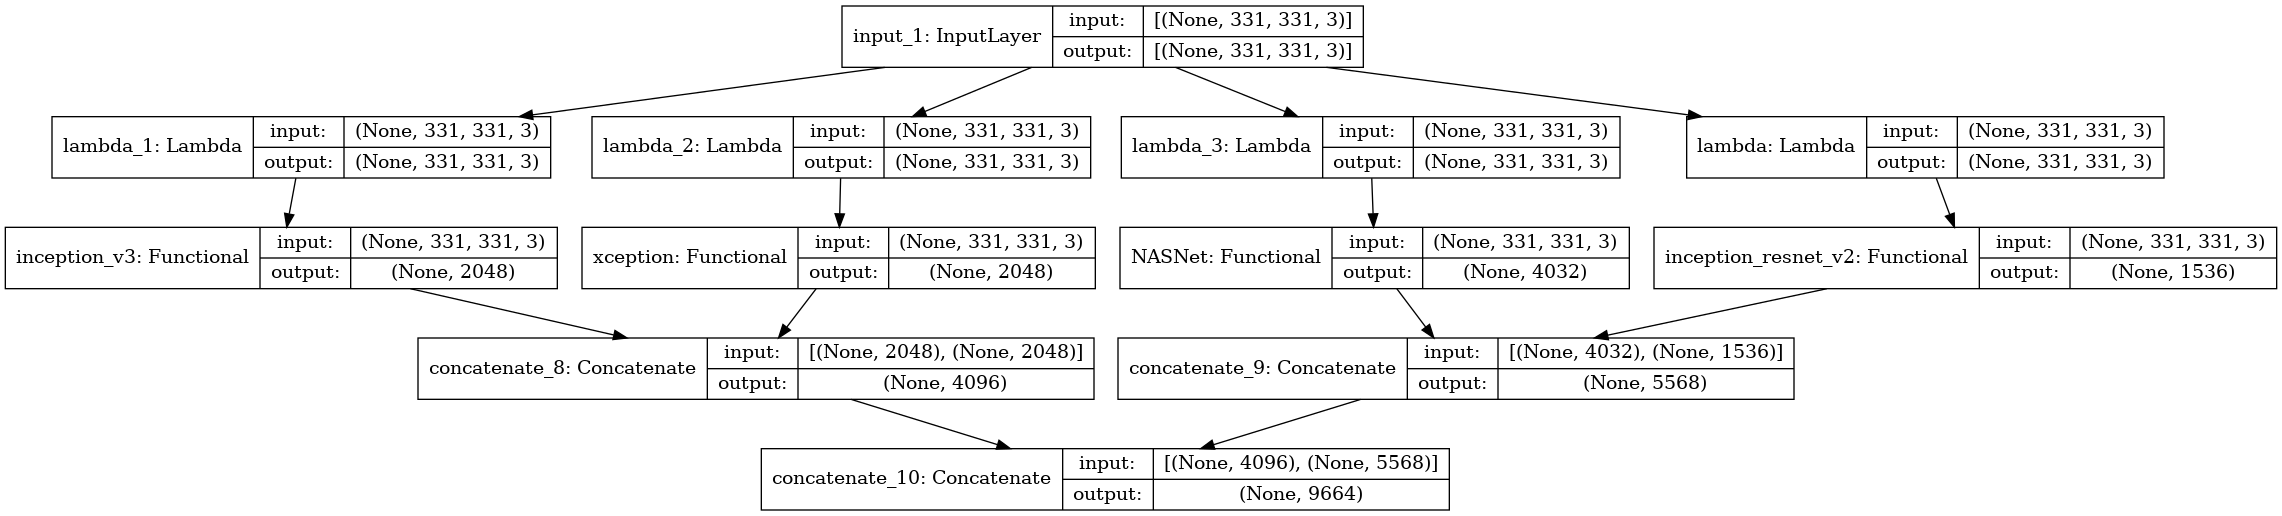

In [26]:
plot_model(model_3,show_shapes = True)

> ***ENCODING***

In [27]:
def feature_extractor(df):
    img_size = (331,331,3)
    data_size = len(df)
    batch_size = 20
    X = np.zeros([data_size,5632], dtype=np.uint8)
    datagen = ImageDataGenerator()
    generator = datagen.flow_from_dataframe(df,
    x_col = 'file_name', class_mode = None, 
    batch_size=20, shuffle = False,target_size = (img_size[:2]),color_mode = 'rgb')
    i = 0
    for input_batch in tqdm(generator):
        input_batch = model_1.predict(input_batch)
        X[i * batch_size : (i + 1) * batch_size] = input_batch
        i += 1
        if i * batch_size >= data_size:
           break
    return X

In [28]:
import time 
t = time.time()
X = feature_extractor(labels_dataframe)
print('runtime in seconds: {}'.format(time.time() - t))

Found 10222 validated image filenames.


  0%|          | 0/512 [00:00<?, ?it/s]2022-11-15 11:43:53.462834: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-15 11:43:59.712528: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
100%|█████████▉| 511/512 [04:47<00:00,  1.78it/s]

runtime in seconds: 298.65443658828735


**CALLBACK**

In [29]:
from keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
EarlyStop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('/kaggle/working/checkpoing',monitor = 'val_loss',mode = 'min',save_best_only= True)
lr = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.5,patience = 3,min_lr = 0.00001)
my_callback=[EarlyStop_callback,checkpoint]

**TRAINING MODEL 1**

In [30]:
dnn = keras.models.Sequential([InputLayer(X.shape[1:]),Dropout(0.7), Dense(n_classes, activation='softmax')])
dnn.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
h = dnn.fit(X , y,batch_size=128,epochs=60,validation_split=0.1 ,callbacks = my_callback)
print('runtime in seconds: {}'.format(time.time() - t))

Epoch 1/60
72/72 [==============================] - 1s 5ms/step - loss: 4.3229 - accuracy: 0.3520 - val_loss: 3.6937 - val_accuracy: 0.8543


2022-11-15 11:48:41.756973: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/60
72/72 [==============================] - 0s 3ms/step - loss: 3.1630 - accuracy: 0.7777 - val_loss: 2.6984 - val_accuracy: 0.8778
Epoch 3/60
72/72 [==============================] - 0s 3ms/step - loss: 2.3252 - accuracy: 0.8411 - val_loss: 2.0424 - val_accuracy: 0.8827
Epoch 4/60
72/72 [==============================] - 0s 3ms/step - loss: 1.8301 - accuracy: 0.8659 - val_loss: 1.6253 - val_accuracy: 0.8935
Epoch 5/60
72/72 [==============================] - 0s 3ms/step - loss: 1.4995 - accuracy: 0.8831 - val_loss: 1.3516 - val_accuracy: 0.8993
Epoch 6/60
72/72 [==============================] - 0s 3ms/step - loss: 1.2865 - accuracy: 0.8893 - val_loss: 1.1616 - val_accuracy: 0.9022
Epoch 7/60
72/72 [==============================] - 0s 3ms/step - loss: 1.1388 - accuracy: 0.8928 - val_loss: 1.0231 - val_accuracy: 0.9022
Epoch 8/60
72/72 [==============================] - 0s 3ms/step - loss: 1.0178 - accuracy: 0.9022 - val_loss: 0.9170 - val_accuracy: 0.9091
Epoch 9/60
72/72 [==

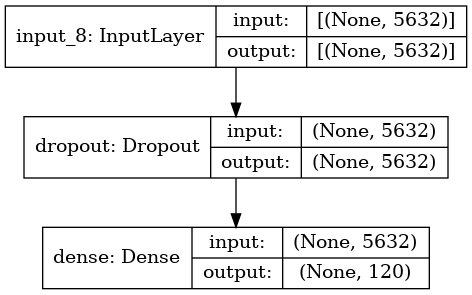

In [31]:
plot_model(dnn,show_shapes = True)

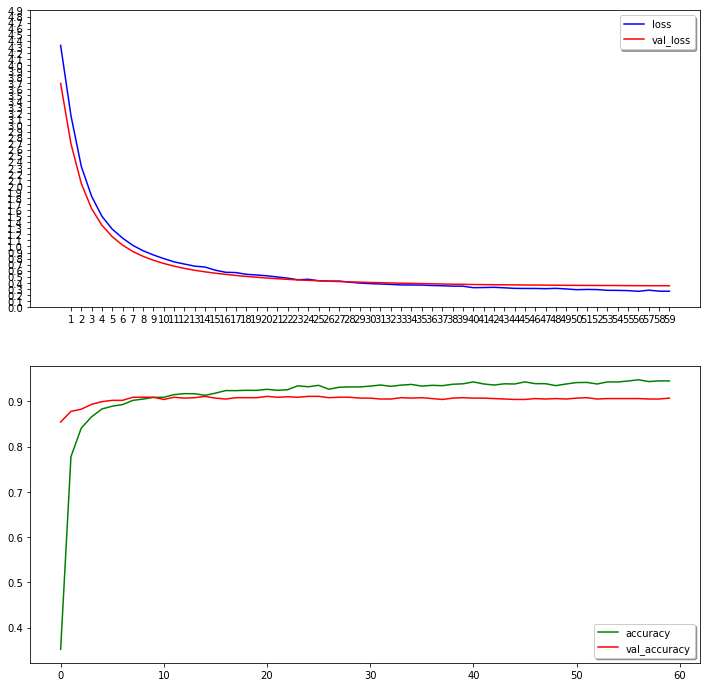

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(h.history['loss'],color = 'b',label = 'loss')
ax1.plot(h.history['val_loss'],color = 'r',label = 'val_loss')
ax1.set_xticks(np.arange(1, 60, 1))
ax1.set_yticks(np.arange(0, 5, 0.1))
ax1.legend(['loss','val_loss'],shadow = True)


ax2.plot(h.history['accuracy'],color = 'green',label = 'accuracy')
ax2.plot(h.history['val_accuracy'],color = 'red',label = 'val_accuracy')
ax2.legend(['accuracy','val_accuracy'],shadow = True)
plt.show()

**PREDICTION MODEL 1**

In [33]:
test_data = []
for pic in os.listdir(test_dir):
    test_data.append(test_dir+pic)
test_dataframe = pd.DataFrame({'file_name':test_data})


In [ ]:
test_features = feature_extractor(test_dataframe)
print('runtime in seconds: {}'.format(time.time() - t))

Found 10357 validated image filenames.


 49%|████▉     | 253/518 [02:16<02:28,  1.78it/s]

In [ ]:
pred = dnn.predict(test_features)

In [ ]:
print(pred[0])
print(f"Max value (probability of prediction): {np.max(pred[0])}")
print(f"Sum: {np.sum(pred[0])}") 
print(f"Max index: {np.argmax(pred[0])}") 

In [ ]:
def get_key(val): 
        for key, value in class_to_num.items(): 
         if val == value: 
             return key 
            
pred_codes = np.argmax(pred, axis = 1)
predictions = []
for i in pred_codes:
    predictions.append(get_key(i))
test_dataframe['breed'] = predictions
test_dataframe

# **MODEL 2**

In [ ]:
def feature_extractor(df):
    img_size = (331,331,3)
    data_size = len(df)
    batch_size = 20
    X = np.zeros([data_size,9664], dtype=np.uint8)
    datagen = ImageDataGenerator()
    generator = datagen.flow_from_dataframe(df,x_col = 'file_name', class_mode = None, batch_size=20, shuffle = False,target_size = (img_size[:2]),color_mode = 'rgb')
    i = 0
    for input_batch in tqdm(generator):
        input_batch = model_2.predict(input_batch)
        X[i * batch_size : (i + 1) * batch_size] = input_batch
        i += 1
        if i * batch_size >= data_size:
           break
    return X

In [ ]:
X = feature_extractor(labels_dataframe)
print('runtime in seconds: {}'.format(time.time() - t))

In [ ]:
dnn = keras.models.Sequential([InputLayer(X.shape[1:]),Dropout(0.7), Dense(n_classes, activation='softmax')])
dnn.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
h = dnn.fit(X , y,batch_size=128,epochs=60,validation_split=0.1 ,callbacks = my_callback)
print('runtime in seconds: {}'.format(time.time() - t))

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(h.history['loss'],color = 'b',label = 'loss')
ax1.plot(h.history['val_loss'],color = 'r',label = 'val_loss')
ax1.set_xticks(np.arange(1, 60, 1))
ax1.set_yticks(np.arange(0, 5, 0.1))
ax1.legend(['loss','val_loss'],shadow = True)


ax2.plot(h.history['accuracy'],color = 'green',label = 'accuracy')
ax2.plot(h.history['val_accuracy'],color = 'red',label = 'val_accuracy')
ax2.legend(['accuracy','val_accuracy'],shadow = True)
plt.show()

In [ ]:
test_data = []
for pic in os.listdir(test_dir):
    test_data.append(test_dir+pic)
test_dataframe = pd.DataFrame({'file_name':test_data})

In [ ]:
test_features = feature_extractor(test_dataframe)
print('runtime in seconds: {}'.format(time.time() - t))

In [ ]:
pred = dnn.predict(test_features)

In [ ]:
print(pred[0])
print(f"Max value (probability of prediction): {np.max(pred[0])}")
print(f"Sum: {np.sum(pred[0])}") 
print(f"Max index: {np.argmax(pred[0])}") 

In [ ]:
def get_key(val): 
        for key, value in class_to_num.items(): 
         if val == value: 
             return key 
            
pred_codes = np.argmax(pred, axis = 1)
predictions = []
for i in pred_codes:
    predictions.append(get_key(i))
test_dataframe['breed'] = predictions
test_dataframe

# **MODEL 3**

In [ ]:
def feature_extractor(df):
    img_size = (331,331,3)
    data_size = len(df)
    batch_size = 20
    X = np.zeros([data_size,9664], dtype=np.uint8)
    datagen = ImageDataGenerator()
    generator = datagen.flow_from_dataframe(df,x_col = 'file_name', class_mode = None, batch_size=20, shuffle = False,target_size = (img_size[:2]),color_mode = 'rgb')
    i = 0
    for input_batch in tqdm(generator):
        input_batch = model_3.predict(input_batch)
        X[i * batch_size : (i + 1) * batch_size] = input_batch
        i += 1
        if i * batch_size >= data_size:
           break
    return X

In [ ]:
X = feature_extractor(labels_dataframe)
print('runtime in seconds: {}'.format(time.time() - t))

In [ ]:
dnn = keras.models.Sequential([InputLayer(X.shape[1:]),Dropout(0.7), Dense(n_classes, activation='softmax')])
dnn.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
h = dnn.fit(X , y,batch_size=128,epochs=60,validation_split=0.1 ,callbacks = my_callback)
print('runtime in seconds: {}'.format(time.time() - t))

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(h.history['loss'],color = 'b',label = 'loss')
ax1.plot(h.history['val_loss'],color = 'r',label = 'val_loss')
ax1.set_xticks(np.arange(1, 60, 1))
ax1.set_yticks(np.arange(0, 5, 0.1))
ax1.legend(['loss','val_loss'],shadow = True)


ax2.plot(h.history['accuracy'],color = 'green',label = 'accuracy')
ax2.plot(h.history['val_accuracy'],color = 'red',label = 'val_accuracy')
ax2.legend(['accuracy','val_accuracy'],shadow = True)
plt.show()

In [ ]:
test_data = []
for pic in os.listdir(test_dir):
    test_data.append(test_dir+pic)
test_dataframe = pd.DataFrame({'file_name':test_data})

In [ ]:
test_features = feature_extractor(test_dataframe)
print('runtime in seconds: {}'.format(time.time() - t))

In [ ]:
pred = dnn.predict(test_features)

In [ ]:
print(pred[0])
print(f"Max value (probability of prediction): {np.max(pred[0])}")
print(f"Sum: {np.sum(pred[0])}") 
print(f"Max index: {np.argmax(pred[0])}") 

In [ ]:
def get_key(val): 
        for key, value in class_to_num.items(): 
         if val == value: 
             return key 
            
pred_codes = np.argmax(pred, axis = 1)
predictions = []
for i in pred_codes:
    predictions.append(get_key(i))
test_dataframe['breed'] = predictions
test_dataframe

# **MODEL 4**

In [ ]:
from tensorflow.keras.layers import Convolution2D, Flatten, Dense
from tensorflow.keras.layers import Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential

model_4 = Sequential([
    Convolution2D(512, kernel_size=(3,3), activation='relu', padding="same", input_shape=(331, 331, 3)),
    MaxPooling2D((2,2), strides=(2,2)),
    Flatten(),
    Dense(10, activation='relu'),
    Dropout(0.7)])


In [ ]:
model_4.summary()

In [ ]:
plot_model(model_4,show_shapes = True)

In [ ]:
def feature_extractor(df):
    img_size = (331,331,3)
    data_size = len(df)
    batch_size = 20
    X = np.zeros([data_size,10], dtype=np.uint8)
    datagen = ImageDataGenerator()
    generator = datagen.flow_from_dataframe(df,
    x_col = 'file_name', class_mode = None, 
    batch_size=20, shuffle = False,target_size = (img_size[:2]),color_mode = 'rgb')
    i = 0
    for input_batch in tqdm(generator):
        input_batch = model_4.predict(input_batch)
        X[i * batch_size : (i + 1) * batch_size] = input_batch
        i += 1
        if i * batch_size >= data_size:
           break
    return X

In [ ]:
import time 
t = time.time()
X = feature_extractor(labels_dataframe)
print('runtime in seconds: {}'.format(time.time() - t))

In [ ]:
dnn = keras.models.Sequential([InputLayer(X.shape[1:]),Dropout(0.7), Dense(n_classes, activation='softmax')])
dnn.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
h = dnn.fit(X , y,batch_size=128,epochs=60,validation_split=0.1 ,callbacks = my_callback)
print('runtime in seconds: {}'.format(time.time() - t))

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(h.history['loss'],color = 'b',label = 'loss')
ax1.plot(h.history['val_loss'],color = 'r',label = 'val_loss')
ax1.set_xticks(np.arange(1, 60, 1))
ax1.set_yticks(np.arange(0, 5, 0.1))
ax1.legend(['loss','val_loss'],shadow = True)


ax2.plot(h.history['accuracy'],color = 'green',label = 'accuracy')
ax2.plot(h.history['val_accuracy'],color = 'red',label = 'val_accuracy')
ax2.legend(['accuracy','val_accuracy'],shadow = True)
plt.show()

In [ ]:
test_data = []
for pic in os.listdir(test_dir):
    test_data.append(test_dir+pic)
test_dataframe = pd.DataFrame({'file_name':test_data})

In [ ]:
test_features = feature_extractor(test_dataframe)
print('runtime in seconds: {}'.format(time.time() - t))

In [ ]:
pred = dnn.predict(test_features)

In [ ]:
print(pred[0])
print(f"Max value (probability of prediction): {np.max(pred[0])}")
print(f"Sum: {np.sum(pred[0])}") 
print(f"Max index: {np.argmax(pred[0])}") 

In [ ]:
def get_key(val): 
        for key, value in class_to_num.items(): 
         if val == value: 
             return key 
            
pred_codes = np.argmax(pred, axis = 1)
predictions = []
for i in pred_codes:
    predictions.append(get_key(i))
test_dataframe['breed'] = predictions
test_dataframe

# **MODEL 5**